In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Converting a Keras Model to JSON Format

In the previous lesson, you saw how to use a CNN to make your recognition of the handwriting digits more efficient. Now you'll take that to the next level: recognizing real images of cats and dogs to classify an incoming image as one or the other. In particular, the handwriting recognition made your life a little easier by having all the images be the same size and shape, and they were all monochrome color. Real-world images aren't like that -- they're in different shapes, aspect ratios etc, and they're usually in color!

So, as part of the task you need to process your data -- not least resizing it to be uniform in shape. 

You'll follow these steps:

1. Explore the example data of cats and dogs.
2. Build and train a neural network to recognize the difference between the two.
3. Evaluate the training and validation accuracy.
4. Save the trained model as a Keras HDF5 file.
5. Use the tensorflow.js converter to convert the saved Keras model into JSON format.

## Import Tensorflow

**NOTE:** You need to use Tensorflow v2.2 in this lab for compatibility with the autograder. Please be aware of this in case you decide to use your own machine or Google Colab. To complete the requirements for this course, we recommend using the Coursera Lab environment first to avoid grader errors about incompatible models. Once you've passed it, feel free to export the notebook to another machine with a more recent Tensorflow version. Most, if not all, of the commands will stay the same but the model output will be a bit different in later versions.

In [1]:
import tensorflow as tf

# This should show version 2.2 to match the autograder
print('\u2022 Using TensorFlow Version:', tf.__version__)

• Using TensorFlow Version: 2.2.0


## Explore the Example Data

We'll be using only 2,000 images taken from the original ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) dataset available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

These are saved in your workspace under the `./data/cats_and_dogs_filtered` folder. This contains `train` and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain `cats` and `dogs` subdirectories.

In short: The training set is the data that is used to tell the neural network model that 'this is what a cat looks like', 'this is what a dog looks like' etc. The validation data set is images of cats and dogs that the neural network will not see as part of the training, so you can test how well or how badly it does in evaluating if an image contains a cat or a dog.

One thing to pay attention to in this sample: We do not explicitly label the images as cats or dogs. If you remember with the handwriting example earlier, we had labelled 'this is a 1', 'this is a 7' etc.  Later you'll see something called an ImageGenerator being used -- and this is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. So, for example, you will have a 'training' directory containing a 'cats' directory and a 'dogs' one. ImageGenerator will label the images appropriately for you, reducing a coding step. 

Let's define each of these directories:


In [ ]:
!unzip archive_data.zip

Archive:  archive_data.zip
replace skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (1).webp? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import os

base_dir = './skin-disease-datasaet'

train_dir = os.path.join(base_dir, 'train_set')
validation_dir = os.path.join(base_dir, 'test_set')

# Directory with our training cat/dog pictures
train_1_dir = os.path.join(train_dir, 'BA- cellulitis')
train_2_dir = os.path.join(train_dir, 'BA-impetigo')
train_3_dir = os.path.join(train_dir, 'FU-athlete-foot')
train_4_dir = os.path.join(train_dir, 'FU-nail-fungus')
train_5_dir = os.path.join(train_dir, 'FU-ringworm')
train_6_dir = os.path.join(train_dir, 'PA-cutaneous-larva-migrans')
train_7_dir = os.path.join(train_dir, 'VI-chickenpox')
train_8_dir = os.path.join(train_dir, 'VI-shingles')

# Directory with our training cat/dog pictures
test_1_dir = os.path.join(validation_dir, 'BA- cellulitis')
test_2_dir = os.path.join(validation_dir, 'BA-impetigo')
test_3_dir = os.path.join(validation_dir, 'FU-athlete-foot')
test_4_dir = os.path.join(validation_dir, 'FU-nail-fungus')
test_5_dir = os.path.join(validation_dir, 'FU-ringworm')
test_6_dir = os.path.join(validation_dir, 'PA-cutaneous-larva-migrans')
test_7_dir = os.path.join(validation_dir, 'VI-chickenpox')
test_8_dir = os.path.join(validation_dir, 'VI-shingles')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [4]:
train_1_fnames = os.listdir( train_1_dir )
train_2_fnames = os.listdir( train_2_dir )
train_3_fnames = os.listdir( train_3_dir )
train_4_fnames = os.listdir( train_4_dir )
train_5_fnames = os.listdir( train_5_dir )
train_6_fnames = os.listdir( train_6_dir )
train_7_fnames = os.listdir( train_7_dir )
train_8_fnames = os.listdir( train_8_dir )

print(train_1_fnames[:10])
print(train_2_fnames[:10])
print(train_3_fnames[:10])
print(train_4_fnames[:10])
print(train_5_fnames[:10])
print(train_6_fnames[:10])
print(train_7_fnames[:10])
print(train_8_fnames[:10])

['BA- cellulitis (114).jpg', 'BA- cellulitis (42).jpg', 'BA- cellulitis (150).jpg', 'BA- cellulitis (24).jpg', 'BA- cellulitis (132).jpg', 'BA- cellulitis (60).jpg', 'BA- cellulitis (15).jpg', 'BA- cellulitis (1).jpeg', 'BA- cellulitis (123).jpg', 'BA- cellulitis (51).jpg']
['24_BA-impetigo (67).jpg', '94_BA-impetigo (6).jpg', '25_BA-impetigo (48).jpg', '65_BA-impetigo (3).jpeg', '67_BA-impetigo (1).jpeg', '45_BA-impetigo (37).jpg', '34_BA-impetigo (40).jpg', '99_BA-impetigo (45).jpg', '55_BA-impetigo (10).jpg', '4_BA-impetigo (34).jpg']
['FU-athlete-foot (57).jpg', 'FU-athlete-foot (93).jpg', 'FU-athlete-foot (75).jpg', 'FU-athlete-foot (7).jpeg', 'FU-athlete-foot (16).jpeg', 'FU-athlete-foot (39).jpg', 'FU-athlete-foot (66).jpg', 'FU-athlete-foot (84).jpg', 'FU-athlete-foot (48).jpg', 'FU-athlete-foot (22).jpg']
['_3_6280.jpg', '_65_1313.jpg', '_37_3886.jpg', '_51_6878.jpg', '_37_3778.jpg', '_46_5785.jpg', '_71_9396.jpg', '_61_4215.jpg', '_21_9438.jpg', '_44_3646.jpg']
['26_FU-ringwo

Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [5]:
print('total training 1 images :', len(os.listdir(train_1_dir) ))
print('total training 2 images :', len(os.listdir(train_2_dir) ))
print('total training 3 images :', len(os.listdir(train_3_dir) ))
print('total training 4 images :', len(os.listdir(train_4_dir) ))
print('total training 5 images :', len(os.listdir(train_5_dir) ))
print('total training 6 images :', len(os.listdir(train_6_dir) ))
print('total training 7 images :', len(os.listdir(train_7_dir) ))
print('total training 8 images :', len(os.listdir(train_8_dir) ))

print('total test 1 images :', len(os.listdir(test_1_dir) ))
print('total test 2 images :', len(os.listdir(test_2_dir) ))
print('total test 3 images :', len(os.listdir(test_3_dir) ))
print('total test 4 images :', len(os.listdir(test_4_dir) ))
print('total test 5 images :', len(os.listdir(test_5_dir) ))
print('total test 6 images :', len(os.listdir(test_6_dir) ))
print('total test 7 images :', len(os.listdir(test_7_dir) ))
print('total test 8 images :', len(os.listdir(test_8_dir) ))

total training 1 images : 136
total training 2 images : 80
total training 3 images : 124
total training 4 images : 129
total training 5 images : 90
total training 6 images : 100
total training 7 images : 136
total training 8 images : 130
total test 1 images : 34
total test 2 images : 20
total test 3 images : 32
total test 4 images : 33
total test 5 images : 23
total test 6 images : 25
total test 7 images : 34
total test 8 images : 33


For both cats and dogs, we have 1,000 training images and 500 validation images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, we configure the `matplotlib` parameters:

In [6]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 224
ncols = 224

pic_index = 0 # Index for iterating over images

It may not be obvious from looking at the images in this grid, but an important note here, and a significant difference from the previous lesson is that these images come in all shapes and sizes. When you did the handwriting recognition example, you had 28x28 greyscale images to work with. These are color and in a variety of shapes. Before training a Neural network with them you'll need to tweak the images. You'll see that in the next section.

Ok, now that you have an idea for what your data looks like, the next step is to define the model that will be trained to recognize cats or dogs from these images 

## Building a Small Model from Scratch to Get to ~72% Accuracy

In the previous section you saw that the images were in a variety of shapes and sizes. In order to train a neural network to handle them you'll need them to be in a uniform size. We've chosen 150x150 for this, and you'll see the code that preprocesses the images to that shape shortly. 

But before we continue, let's start defining the model. We will define a Sequential layer as before, adding some convolutional layers first. Note the input shape parameter this time. In the earlier example it was 28x28x1, because the image was 28x28 in greyscale (8 bits, 1 byte for color depth). This time it is 150x150 for the size and 3 (24 bits, 3 bytes) for the color depth. 

We then add a couple of convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.

Finally we add the densely connected layers. 

Note that because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [ ]:
# model = tf.keras.models.Sequential([
#     # Note the input shape is the desired size of the image 150x150 with 3 bytes color
#     tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2), 
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
#     tf.keras.layers.MaxPooling2D(2,2),
#     # Flatten the results to feed into a DNN
#     tf.keras.layers.Flatten(), 
#     # 512 neuron hidden layer
#     tf.keras.layers.Dense(512, activation='relu'), 
#     tf.keras.layers.Dense(8, activation='softmax')  
# ])

In [18]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

In [19]:
base_model.trainable = False

In [20]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce dimensions
x = Dropout(0.5)(x)              # Dropout for regularization
x = Dense(512, activation='relu')(x)  # Fully connected layer with 512 neurons
predictions = Dense(8, activation='softmax')(x)  # Output layer for 8 classes

In [21]:
from tensorflow.keras.models import Model

model = Model(inputs=base_model.input, outputs=predictions)

The `model.summary()` method call prints a summary of the NN 

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [23]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit`, `evaluate_generator`, and `predict_generator`.

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=64,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))


Found 924 images belonging to 8 classes.
Found 233 images belonging to 8 classes.


### Training

Let's train on all 2,000 images available, for 15 epochs, and validate on all 1,000 test images. (This may take a few minutes to run.)

Do note the values per epoch. You'll see 4 metrics -- loss, accuracy, validation loss and validation accuracy. 

The loss and accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. The validation accuracy is the measurement with the data that has not been used in training. As expected this would be a bit lower. You'll learn about why this occurs in the section on overfitting later in this course. You are also given a callback function to stop the training when both the training and validation accuracy exceeds 70 percent.

In [ ]:
# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if(logs.get('acc')>0.8 and logs.get('val_acc')>0.8):
#             print("\nReached 99.8% accuracy so cancelling training!")
#             self.model.stop_training = True

# callbacks = myCallback()

In [25]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_steps=50,
    verbose=1,
)

Epoch 1/10
100/100 [==============================] - 431s 4s/step - loss: 0.3746 - accuracy: 0.8774 - val_loss: 0.2153 - val_accuracy: 0.9189
Epoch 2/10
100/100 [==============================] - 423s 4s/step - loss: 0.0658 - accuracy: 0.9789 - val_loss: 0.1238 - val_accuracy: 0.9652
Epoch 3/10
100/100 [==============================] - 421s 4s/step - loss: 0.0499 - accuracy: 0.9824 - val_loss: 0.1209 - val_accuracy: 0.9573
Epoch 4/10
100/100 [==============================] - 426s 4s/step - loss: 0.0283 - accuracy: 0.9916 - val_loss: 0.1027 - val_accuracy: 0.9655
Epoch 5/10
100/100 [==============================] - 425s 4s/step - loss: 0.0233 - accuracy: 0.9922 - val_loss: 0.1495 - val_accuracy: 0.9573
Epoch 6/10
100/100 [==============================] - 421s 4s/step - loss: 0.0216 - accuracy: 0.9927 - val_loss: 0.1047 - val_accuracy: 0.9607
Epoch 7/10
100/100 [==============================] - 422s 4s/step - loss: 0.0231 - accuracy: 0.9918 - val_loss: 0.1306 - val_accuracy: 0.9617

### Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

Text(0.5, 1.0, 'Training and validation loss')

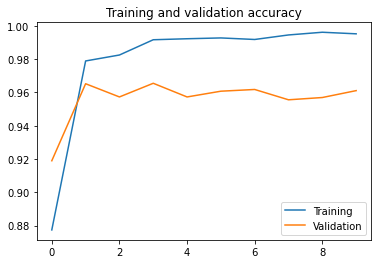

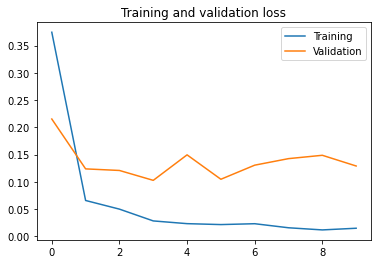

In [26]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

As you can see, we are **overfitting** like it's getting out of fashion. Our training accuracy (in blue) gets close to 100% (!) while our validation accuracy (in orange) stalls as 70%. Our validation loss reaches its minimum after only five epochs.

Since we have a relatively small number of training examples (2000), overfitting should be our number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three images of people who are sailors, and among them the only person wearing a cap is a lumberjack, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Overfitting is the central problem in machine learning: given that we are fitting the parameters of our model to a given dataset, how can we make sure that the representations learned by the model will be applicable to data never seen before? How do we avoid learning things that are specific to the training data?

In the next exercise, we'll look at ways to prevent overfitting in the cat vs. dog classification model.

## Save the Model

In the cell below, save the trained model as a Keras model (`.h5` file).

**HINT**: Use `model.save()`. Feel free to take a look at the `Linear-to-JavaScript.ipynb` example.

In [22]:
# EXERCISE: Save the trained model as a Keras HDF5 file. 

saved_model_path = "./model_training.h5"

# YOUR CODE HERE
model.save(saved_model_path)


In [ ]:
!mkdir tes1

## Run the TensorFlow.js Converter on The Saved Keras Model

In the cell below, use the `tensorflowjs_converter` to convert the saved Keras model into JSON format.

**HINT**: Make sure you specify the format of the input model as Keras by using the `--input_format` option. Feel free to take a look at the `Linear-to-JavaScript.ipynb` example and the [TensorFlow.js converter documentation](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter#step-1-converting-a-tensorflow-savedmodel-tensorflow-hub-module-keras-hdf5-or-tfkeras-savedmodel-to-a-web-friendly-format). There's also an extra commented line below in case you need to re-run the converter and want to delete previously generated files.

In [24]:
# EXERCISE: Use the tensorflow.js converter to convert the saved Keras model into JSON format.

# Uncomment the next line if you want to clear previously generated .bin and json files before running the converter
# !rm *.bin model.json submission.zip

# YOUR CODE HERE
! tensorflowjs_converter \
  --input_format=keras \
  model_training.h5 \
  "./tes1"

If you did things correctly, you should now have a **JSON** file named `model.json` and various `.bin` files, such as `group1-shard1of10.bin`. The number of `.bin` files will depend on the size of your model: the larger your model, the greater the number of `.bin` files. The `model.json` file contains the architecture of your model and the `.bin` files will contain the weights of your model.

You can use the next line to zip all the necessary files for the grader. After running this, click `Lab Files` on the upper right of this Coursera Labs environment, click on `/home/jovyan/work`, then find `submission.zip`. You can then click on the checkbox beside it, then click `Download` at the top to save it locally. You'll then upload this to the grader in the next classroom item.

In [26]:
# compress necessary files for grading
!zip -r training.zip /home/jovyan/work/tes1

updating: home/jovyan/work/tes1/ (stored 0%)
  adding: home/jovyan/work/tes1/group1-shard12of22.bin (deflated 7%)
  adding: home/jovyan/work/tes1/group1-shard3of22.bin (deflated 7%)
  adding: home/jovyan/work/tes1/group1-shard21of22.bin (deflated 7%)
  adding: home/jovyan/work/tes1/group1-shard16of22.bin (deflated 7%)
  adding: home/jovyan/work/tes1/group1-shard7of22.bin (deflated 7%)
  adding: home/jovyan/work/tes1/group1-shard14of22.bin (deflated 7%)
  adding: home/jovyan/work/tes1/group1-shard5of22.bin (deflated 7%)
  adding: home/jovyan/work/tes1/group1-shard18of22.bin (deflated 7%)
  adding: home/jovyan/work/tes1/group1-shard9of22.bin (deflated 7%)
  adding: home/jovyan/work/tes1/group1-shard1of22.bin (deflated 7%)
  adding: home/jovyan/work/tes1/group1-shard10of22.bin (deflated 7%)
  adding: home/jovyan/work/tes1/group1-shard13of22.bin (deflated 7%)
  adding: home/jovyan/work/tes1/group1-shard4of22.bin (deflated 7%)
  adding: home/jovyan/work/tes1/group1-shard22of22.bin (deflated